<a href="https://colab.research.google.com/github/fengfrankgthb/BUS-41204/blob/main/Deep%20Learning/Xray_resnet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-ray Classification with ResNet18

## Overview

This notebook demonstrates how to load a preprocessed X-ray dataset, fine-tune a pretrained ResNet-18 model for binary classification, and evaluate its performance. The focus is on exploring how well transfer learning can work when only a small amount of labeled training data is available. We analyze the model’s ability to generalize and discuss ways to improve performance under data-scarce conditions.

In [1]:
from io import BytesIO

import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import models

## Load the Preprocessed Dataset

We load a preprocessed dataset stored in a `.pt` file, which contains PyTorch tensors representing
chest X-ray images and their associated labels. Each label indicates whether the scan shows evidence
of **Infiltration** or if there was **No Finding** in the patient's lungs.

**Remark**: This is a rather big file, the download takes roughly **90 seconds**.

In [ ]:
dropbox_url = "https://www.dropbox.com/scl/fi/f4dm7jx545iifys32rw3n/xray_data.pt?rlkey=khmvzz8rbkxav66jv5u48bg80&st=f7bruilv&dl=1"
response = requests.get(dropbox_url)
response.raise_for_status()
data = torch.load(BytesIO(response.content), weights_only=False)
images = data["images"]
labels = data["labels"]
dataset = TensorDataset(images, labels)

Let's have a look at one image!

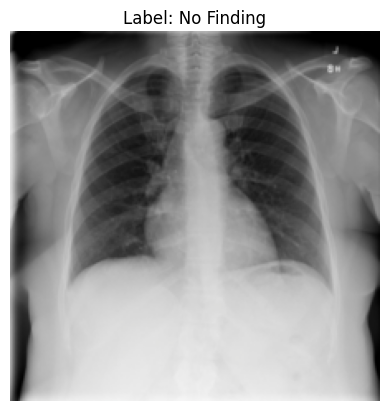

In [ ]:
# Choose an index
idx = 0
image = images[idx]
label = labels[idx]

# Unnormalize
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image * std + mean  # reverse normalization
image = image.clamp(0, 1)  # clip values to [0, 1]

# Plot
plt.imshow(image.permute(1, 2, 0))  # CHW -> HWC
plt.title(f"Label: {'Infiltration' if label == 1 else 'No Finding'}")
plt.axis("off")
plt.show()


## Create Train and Validation Sets

We split the dataset into 70% for training  and 30% for validation. This is a typical
training/validation split.

In [ ]:
train_size = int(0.7 * len(dataset))  # 20% for training
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Model Setup

Convolutional neural networks (CNNs) have become the foundation of modern image analysis, with early
architectures like AlexNet and VGG paving the way for deeper and more powerful models. ResNet-18
continues this evolution by introducing residual connections, which help address the vanishing
gradient problem and enable the training of deeper networks. While much deeper architectures such as
ResNet-50, ResNet-101, or transformer-based models are now common in state-of-the-art applications,
we opt for ResNet-18 due to limited computational resources.

Pretrained on ImageNet, ResNet-18 captures general visual features that can be fine-tuned for domain-specific tasks such as diagnosing conditions from X-ray images. We adapt the final fully connected layer for binary classification to predict a patient’s diagnosis from an X-ray image.

Given a small training set of only 500 images, we leverage transfer learning to compensate for the scarcity of labeled data. By fine-tuning a model that has already learned rich feature representations, we aim to boost performance despite the limited dataset.

Let’s see how well it works!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

## Training Loop
We train the model for 5 epochs, tracking the training loss and accuracy.

**Remark**: Training may take up to 90 minutes on your machine. Everything has already been precompiled, so you don’t need to actually run the code unless you’d like to.

In [ ]:
train_losses = []
train_accuracies = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}: Train Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

Epoch 1: Train Loss = 0.6651, Accuracy = 0.6354
Epoch 2: Train Loss = 0.4333, Accuracy = 0.8154
Epoch 3: Train Loss = 0.2642, Accuracy = 0.9286
Epoch 4: Train Loss = 0.1301, Accuracy = 0.9874
Epoch 5: Train Loss = 0.0527, Accuracy = 1.0000


Let's have a look at the training loss and accuracy.

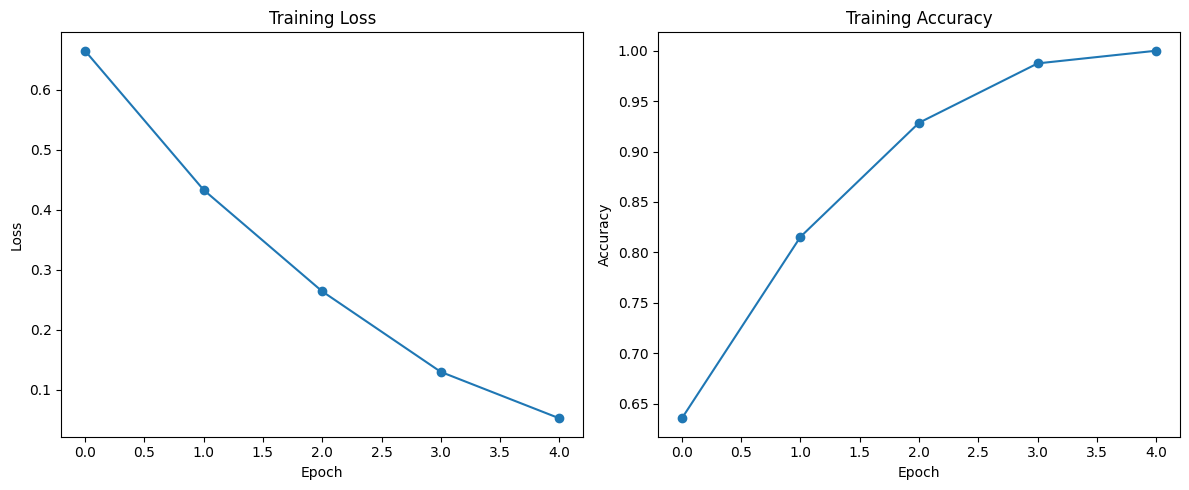

In [ ]:
# Plot training loss and accuracy over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker="o")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker="o")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

## Validation Evaluation
After training, we evaluate the model on the validation set.

Validation Accuracy: 0.6720 (504/750)


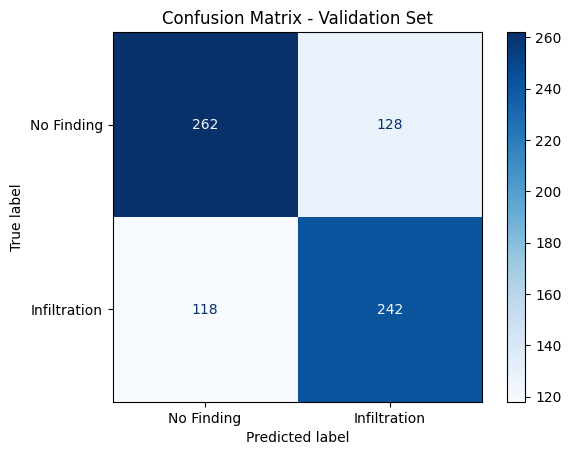

In [ ]:
model.eval()
val_correct = 0
val_total = 0
all_preds = []
all_labels = []

# Accuracy on validation set
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_accuracy = val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_correct}/{val_total})")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Finding", "Infiltration"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.show()

On the validation set, the model achieves an accuracy of roughly 68% (507 out of 750 correct predictions). For context, random guessing would result in around 50% accuracy for a binary classification task, so the model is learning something.

Still, there's plenty of room for improvement.

Here are two approaches to improve the performance:

- **Fine-tune more layers**  
  Instead of freezing the entire backbone, selectively unfreezing the last few blocks (e.g., `layer4`) can help the model adapt better to the target domain.

- **Use a more expressive model**  
  Switching to a deeper architecture like ResNet-50 or EfficientNet (if compute allows) may improve generalization.
